<a href="https://colab.research.google.com/github/guptavik/earv4-assign9/blob/main/imagenet_poc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
import time

# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

print("Libraries imported - ready to use PyTorch", torch.__version__)

def show_image(image, label):
    image = image.permute(1, 2, 0)
    plt.imshow(image.squeeze())
    plt.title(f'Label: {label}')
    plt.show()

Libraries imported - ready to use PyTorch 2.8.0+cu126


In [ ]:
# device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# device="cpu"

print(f"Using {device} device")

# resume training options
resume_training = True

class Params:
    def __init__(self):
        self.batch_size = 16
        self.name = "resnet_152_sgd1"
        self.workers = 4
        self.lr = 0.1
        self.momentum = 0.9
        self.weight_decay = 1e-4
        self.lr_step_size = 30
        self.lr_gamma = 0.1

    def __repr__(self):
        return str(self.__dict__)

    def __eq__(self, other):
        return self.__dict__ == other.__dict__

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
params = Params()
params, params.batch_size

Using cuda device


({'batch_size': 16, 'name': 'resnet_152_sgd1', 'workers': 4, 'lr': 0.1, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_step_size': 30, 'lr_gamma': 0.1},
 16)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%mkdir data

In [ ]:
!cp drive/MyDrive/data/imagenet/imagenet_subset.zip data/
!cp drive/MyDrive/data/imagenet/imagenet_val.zip data/
!unzip /content/data/archive.zip -d /content/data/
!unzip /content/data/imagenet_val.zip -d /content/data/

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/imagenet_validation/n04562935/ILSVRC2012_val_00000586.JPEG  
  inflating: /content/data/imagenet_validation/n04562935/ILSVRC2012_val_00001934.JPEG  
  inflating: /content/data/imagenet_validation/n04562935/ILSVRC2012_val_00003749.JPEG  
  inflating: /content/data/imagenet_validation/n04562935/ILSVRC2012_val_00004393.JPEG  
  inflating: /content/data/imagenet_validation/n04562935/ILSVRC2012_val_00004536.JPEG  
  inflating: /content/data/imagenet_validation/n04562935/ILSVRC2012_val_00005342.JPEG  
  inflating: /content/data/imagenet_validation/n04562935/ILSVRC2012_val_00005814.JPEG  
  inflating: /content/data/imagenet_validation/n04562935/ILSVRC2012_val_00007553.JPEG  
  inflating: /content/data/imagenet_validation/n04562935/ILSVRC2012_val_00008486.JPEG  
  inflating: /content/data/imagenet_validation/n04562935/ILSVRC2012_val_00009339.JPEG  
  inflating: /content/data/imagenet_validation/n04562935/ILSVRC2012_v

In [ ]:
!pwd

/content


In [ ]:
!unzip /content/data/imagenet_subset.zip -d /content/data/

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/imagenet_subtrain/n07747607/n07747607_10179.JPEG  
  inflating: /content/data/imagenet_subtrain/n07747607/n07747607_10258.JPEG  
  inflating: /content/data/imagenet_subtrain/n07747607/n07747607_10974.JPEG  
  inflating: /content/data/imagenet_subtrain/n07747607/n07747607_11066.JPEG  
  inflating: /content/data/imagenet_subtrain/n07747607/n07747607_11710.JPEG  
  inflating: /content/data/imagenet_subtrain/n07747607/n07747607_11725.JPEG  
  inflating: /content/data/imagenet_subtrain/n07747607/n07747607_1202.JPEG  
  inflating: /content/data/imagenet_subtrain/n07747607/n07747607_12294.JPEG  
  inflating: /content/data/imagenet_subtrain/n07747607/n07747607_12381.JPEG  
  inflating: /content/data/imagenet_subtrain/n07747607/n07747607_12466.JPEG  
  inflating: /content/data/imagenet_subtrain/n07747607/n07747607_13016.JPEG  
  inflating: /content/data/imagenet_subtrain/n07747607/n07747607_13701.JPEG  
  inflating: /

In [ ]:
! ls /content/data/

imagenet_subset.zip  imagenet_validation  imagenet_val.zip


In [ ]:
!ls /content/data/imagenet_subtrain/

n01440764  n02037110  n02125311  n02799071  n03443371  n03929855  n04435653
n01443537  n02051845  n02127052  n02802426  n03444034  n03930313  n04442312
n01484850  n02056570  n02128385  n02804414  n03445777  n03930630  n04443257
n01491361  n02058221  n02128757  n02804610  n03445924  n03933933  n04447861
n01494475  n02066245  n02128925  n02807133  n03447447  n03935335  n04456115
n01496331  n02071294  n02129165  n02808304  n03447721  n03937543  n04458633
n01498041  n02074367  n02129604  n02808440  n03450230  n03938244  n04461696
n01514668  n02077923  n02130308  n02814533  n03452741  n03942813  n04462240
n01514859  n02085620  n02132136  n02814860  n03457902  n03944341  n04465501
n01518878  n02085782  n02133161  n02815834  n03459775  n03947888  n04467665
n01530575  n02085936  n02134084  n02817516  n03461385  n03950228  n04476259
n01531178  n02086079  n02134418  n02823428  n03467068  n03954731  n04479046
n01532829  n02086240  n02137549  n02823750  n03476684  n03956157  n04482393
n01534433  n

In [ ]:
training_folder_name = '/content/data/imagenet_subtrain'
val_folder_name = '/content/data/imagenet_validation'

In [ ]:
os.listdir(training_folder_name)

['n07614500',
 'n02107312',
 'n01669191',
 'n03337140',
 'n03661043',
 'n02835271',
 'n01829413',
 'n04346328',
 'n03761084',
 'n02264363',
 'n03197337',
 'n02128385',
 'n03496892',
 'n04243546',
 'n02321529',
 'n03887697',
 'n03967562',
 'n02106662',
 'n03788195',
 'n02112706',
 'n03290653',
 'n02113624',
 'n03388183',
 'n03895866',
 'n03100240',
 'n02500267',
 'n02089078',
 'n01665541',
 'n04465501',
 'n01518878',
 'n03876231',
 'n03223299',
 'n02951585',
 'n04074963',
 'n01592084',
 'n02892767',
 'n03485407',
 'n01806567',
 'n03877472',
 'n09428293',
 'n04099969',
 'n04347754',
 'n01734418',
 'n04252077',
 'n02894605',
 'n02817516',
 'n07718747',
 'n03924679',
 'n04548280',
 'n03534580',
 'n04254120',
 'n03447447',
 'n04540053',
 'n03692522',
 'n01978287',
 'n03026506',
 'n03016953',
 'n02107683',
 'n03623198',
 'n02120079',
 'n01697457',
 'n02930766',
 'n04536866',
 'n01950731',
 'n04118776',
 'n03372029',
 'n07615774',
 'n03393912',
 'n02837789',
 'n02101006',
 'n02096437',
 'n021

In [ ]:
os.listdir(training_folder_name)

['n07614500',
 'n02107312',
 'n01669191',
 'n03337140',
 'n03661043',
 'n02835271',
 'n01829413',
 'n04346328',
 'n03761084',
 'n02264363',
 'n03197337',
 'n02128385',
 'n03496892',
 'n04243546',
 'n02321529',
 'n03887697',
 'n03967562',
 'n02106662',
 'n03788195',
 'n02112706',
 'n03290653',
 'n02113624',
 'n03388183',
 'n03895866',
 'n03100240',
 'n02500267',
 'n02089078',
 'n01665541',
 'n04465501',
 'n01518878',
 'n03876231',
 'n03223299',
 'n02951585',
 'n04074963',
 'n01592084',
 'n02892767',
 'n03485407',
 'n01806567',
 'n03877472',
 'n09428293',
 'n04099969',
 'n04347754',
 'n01734418',
 'n04252077',
 'n02894605',
 'n02817516',
 'n07718747',
 'n03924679',
 'n04548280',
 'n03534580',
 'n04254120',
 'n03447447',
 'n04540053',
 'n03692522',
 'n01978287',
 'n03026506',
 'n03016953',
 'n02107683',
 'n03623198',
 'n02120079',
 'n01697457',
 'n02930766',
 'n04536866',
 'n01950731',
 'n04118776',
 'n03372029',
 'n07615774',
 'n03393912',
 'n02837789',
 'n02101006',
 'n02096437',
 'n021

torch.Size([16, 3, 224, 224])


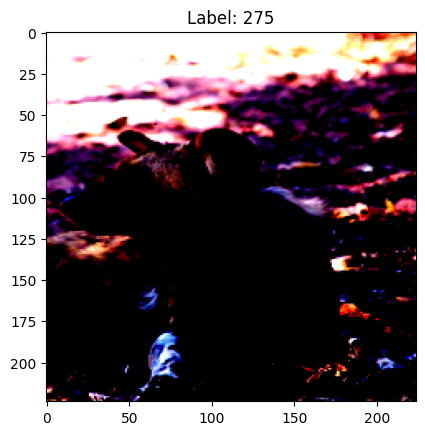

In [ ]:
train_transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomResizedCrop(224, interpolation=transforms.InterpolationMode.BILINEAR, antialias=True),
        transforms.RandomHorizontalFlip(0.5),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.485, 0.485, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dataset = torchvision.datasets.ImageFolder(
    root=training_folder_name,
    transform=train_transformation
)
train_sampler = torch.utils.data.RandomSampler(train_dataset)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=params.batch_size,
    sampler=train_sampler,
    num_workers = params.workers,
    pin_memory=True,
)
for X, y in train_loader:
    break
print(X.shape)
show_image(X[0], y[0])

In [ ]:
train_dataset[1337]

(tensor([[[ 1.5792,  1.4876,  1.3961,  ...,  1.8301,  1.9495,  1.9791],
          [ 1.5326,  1.4240,  1.4394,  ...,  1.6283,  1.5674,  1.5513],
          [ 1.5825,  1.4736,  1.3994,  ...,  1.1709,  1.2270,  1.3613],
          ...,
          [ 0.0644, -0.0309, -0.0195,  ..., -0.1376, -0.1230, -0.0901],
          [-0.0368, -0.1945, -0.1830,  ..., -0.1002, -0.1194, -0.3105],
          [ 0.1992,  0.1105,  0.0606,  ..., -0.5003, -0.7717, -0.6216]],
 
         [[ 1.2007,  1.1070,  1.1208,  ...,  1.5540,  1.6893,  1.7394],
          [ 1.0987,  0.9800,  1.1400,  ...,  1.2749,  1.1573,  1.1235],
          [ 1.1820,  1.0579,  1.0608,  ...,  0.7847,  0.8472,  0.9936],
          ...,
          [-0.1701, -0.3002, -0.2863,  ..., -0.2626, -0.3540, -0.3289],
          [-0.3507, -0.5447, -0.5765,  ..., -0.2351, -0.2915, -0.4898],
          [-0.1612, -0.3173, -0.4214,  ..., -0.6250, -0.8216, -0.7313]],
 
         [[ 0.9730,  0.8677,  0.8684,  ...,  1.0451,  1.1738,  1.2260],
          [ 0.6310,  0.5395,

torch.Size([64, 3, 224, 224])


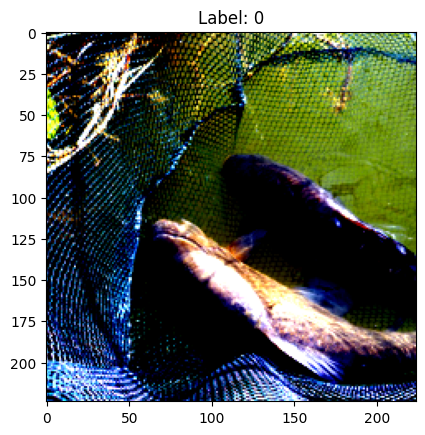

In [ ]:
val_transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size=256, antialias=True),
        transforms.CenterCrop(224),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.485, 0.485, 0.406], std=[0.229, 0.224, 0.225])
    ])
val_dataset = torchvision.datasets.ImageFolder(
    root=val_folder_name,
    transform=val_transformation
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=64,
    num_workers=params.workers,
    shuffle=False,
    pin_memory=True
)
for X, y in val_loader:
    break
print(X.shape)
show_image(X[0], y[0])

📊 EDA on ImageNet Subset
----------------------------------------
Total Training Images: 100000
Total Validation Images: 50000
Number of Classes: 1000

Sample Class Names: ['n01440764', 'n01443537', 'n01484850', 'n01491361', 'n01494475', 'n01496331', 'n01498041', 'n01514668', 'n01514859', 'n01518878'] 



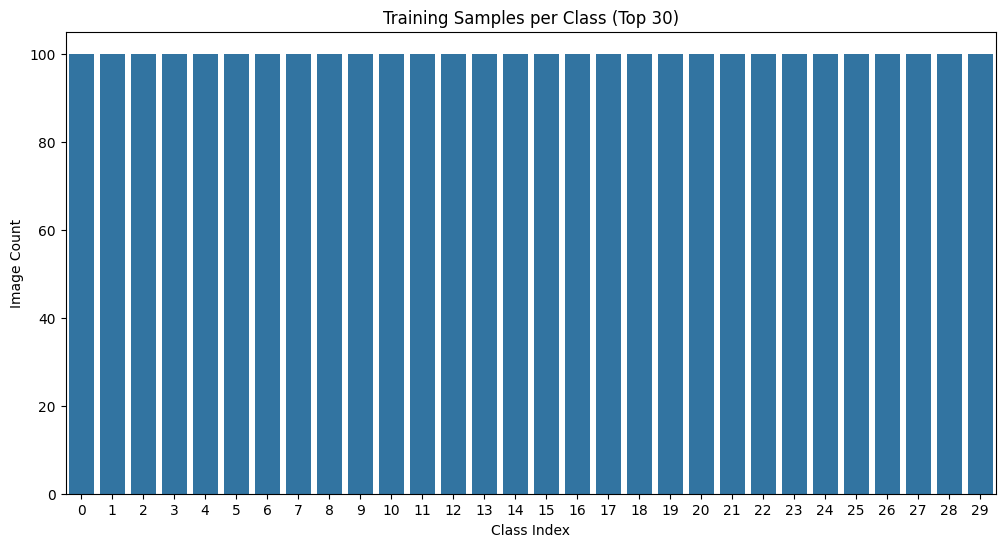


🖼️ Sample Images from Training Set:


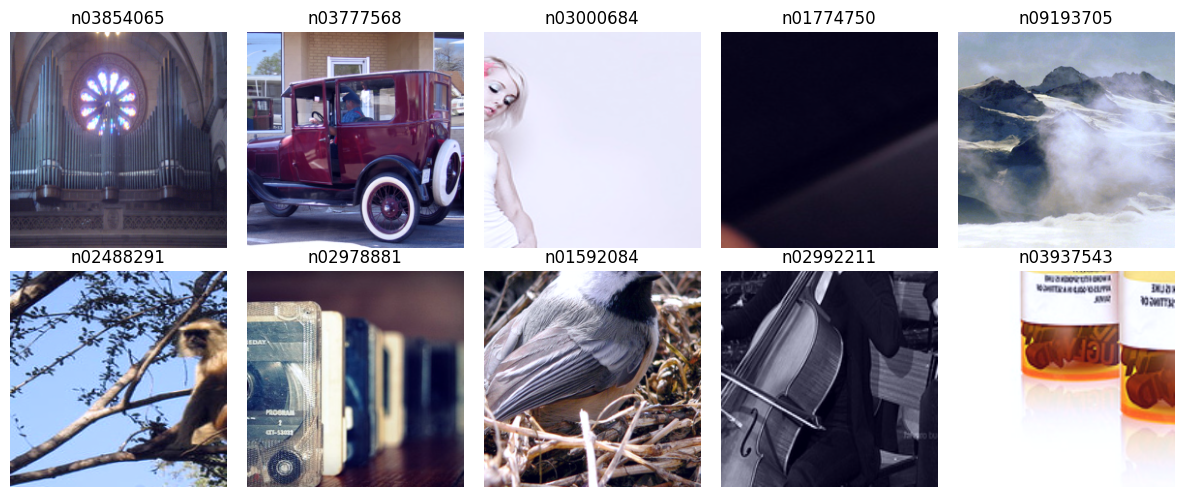

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

def dataset_eda(train_dataset, val_dataset):
    print("📊 EDA on ImageNet Subset")
    print("-" * 40)
    print(f"Total Training Images: {len(train_dataset)}")
    print(f"Total Validation Images: {len(val_dataset)}")
    print(f"Number of Classes: {len(train_dataset.classes)}\n")

    # Print first few class names
    print("Sample Class Names:", train_dataset.classes[:10], "\n")

    # Count images per class
    train_counts = Counter([train_dataset.targets[i] for i in range(len(train_dataset))])
    val_counts = Counter([val_dataset.targets[i] for i in range(len(val_dataset))])

    # Convert to sorted lists for visualization
    class_indices = list(range(len(train_dataset.classes)))
    train_freqs = [train_counts[i] for i in class_indices]
    val_freqs = [val_counts[i] for i in class_indices]

    # Plot class distribution (Top 30 only for readability)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(range(min(30, len(train_freqs)))), y=train_freqs[:30])
    plt.title("Training Samples per Class (Top 30)")
    plt.xlabel("Class Index")
    plt.ylabel("Image Count")
    plt.show()

    # Show a few sample images
    print("\n🖼️ Sample Images from Training Set:")
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    for i, ax in enumerate(axes.flat):
        idx = np.random.randint(len(train_dataset))
        img, label = train_dataset[idx]
        img = img.permute(1, 2, 0).numpy()
        img = np.clip((img * 0.229 + 0.485), 0, 1)  # De-normalize for viewing
        ax.imshow(img)
        ax.set_title(train_dataset.classes[label][:15])
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Run EDA
dataset_eda(train_dataset, val_dataset)


In [ ]:
from math import sqrt
def train(dataloader, model, loss_fn, optimizer, epoch, writer):
    size = len(dataloader.dataset)
    model.train()
    start0 = time.time()
    start = time.time()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        batch_size = len(X)
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * batch_size
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}], {(current/size * 100):>4f}%")
            step = epoch * size + current
            writer.add_scalar('training loss',
                            loss,
                            step)
            new_start = time.time()
            delta = new_start - start
            start = new_start
            if batch != 0:
                print("Done in ", delta, " seconds")
                remaining_steps = size - current
                speed = 100 * batch_size / delta
                remaining_time = remaining_steps / speed
                print("Remaining time (seconds): ", remaining_time)
        optimizer.zero_grad()
    print("Entire epoch done in ", time.time() - start0, " seconds")

In [ ]:
def test(dataloader, model, loss_fn, epoch, writer, train_dataloader, calc_acc5=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct, correct_top5 = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            if calc_acc5:
                _, pred_top5 = pred.topk(5, 1, largest=True, sorted=True)
                correct_top5 += pred_top5.eq(y.view(-1, 1).expand_as(pred_top5)).sum().item()
    test_loss /= num_batches
    step = epoch * len(train_dataloader.dataset)
    if writer != None:
        writer.add_scalar('test loss',
                            test_loss,
                            step)
    correct /= size
    correct_top5 /= size
    if writer != None:
        writer.add_scalar('test accuracy',
                            100*correct,
                            step)
        if calc_acc5:
            writer.add_scalar('test accuracy5',
                            100*correct_top5,
                            step)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    if calc_acc5:
        print(f"Test Error: \n Accuracy-5: {(100*correct_top5):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
## testing a pretrained model to validate correctness of our dataset, transform and metrics code
pretrained_model = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT').to(device)
start = time.time()
loss_fn = nn.CrossEntropyLoss()
test(val_loader, pretrained_model, loss_fn, epoch=0, writer=None, train_dataloader=train_loader, calc_acc5=True)
print("Elapsed: ", time.time() - start)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 240MB/s]


Test Error: 
 Accuracy: 69.5%, Avg loss: 1.254691 

Test Error: 
 Accuracy-5: 88.9%, Avg loss: 1.254691 

Elapsed:  141.24801063537598


In [ ]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=1,
        groups=groups,
        bias=False,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [ ]:
from functools import partial
from typing import Any, Callable, List, Optional, Type, Union
from torch import Tensor
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        base_width: int = 64,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0))
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Bottleneck],
        layers: List[int],
        num_classes: int = 1000,
        width_per_group: int = 64,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(
        self,
        block: Type[Union[Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.base_width, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    base_width=self.base_width,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)

        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [ ]:
device = "cuda"
model = ResNet(Bottleneck, [3, 8, 36, 3]).to(device)
preds = model(X.to(device))
preds.shape

torch.Size([64, 1000])

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=params.lr, momentum=params.momentum, weight_decay=params.weight_decay)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=params.lr_step_size, gamma=params.lr_gamma)

In [ ]:
start_epoch = 0
checkpoint_path = os.path.join("checkpoints", params.name, f"checkpoint.pth")
if resume_training and os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model"])
    start_epoch = checkpoint["epoch"] + 1
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])
    assert params == checkpoint["params"]

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
Path(os.path.join("checkpoints", params.name)).mkdir(parents=True, exist_ok=True)
writer = SummaryWriter('runs/' + params.name)
test(val_loader, model, loss_fn, epoch=0, writer=writer, train_dataloader=train_loader, calc_acc5=True)
for epoch in range(start_epoch, 100):
    train(train_loader, model, loss_fn, optimizer, epoch=epoch, writer=writer)
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "lr_scheduler": lr_scheduler.state_dict(),
        "epoch": epoch,
        "params": params
    }
    torch.save(checkpoint, os.path.join("checkpoints", params.name, f"model_{epoch}.pth"))
    torch.save(checkpoint, os.path.join("checkpoints", params.name, f"checkpoint.pth"))
    lr_scheduler.step()
    test(val_loader, model, loss_fn, epoch + 1, writer, train_dataloader=train_loader, calc_acc5=True)

KeyboardInterrupt: 

In [ ]:
%mkdir /content/drive/MyDrive/projects/imagenet_poc

In [ ]:
!cp -r /content/checkpoints/ /content/drive/MyDrive/projects/imagenet_poc

In [ ]:
!ls /content/drive/MyDrive/projects/imagenet_poc/

checkpoints  runs


In [ ]:
!cp -r /content/runs /content/drive/MyDrive/projects/imagenet_poc